# 

## IllustrisTNG : Total Mass Density Profile of Galaxy to Lenstronomy Simulation and Inference

### Bulk import Python and Lenstronomy Libraries

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd

import lenstronomy


# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

#import emcee for MCMC
import emcee

#import corner module with relevant installations for implementation
import corner

### Load saved TNG galaxy data 

In [114]:
# Load the IllustrisTNG data

galaxy_data = pd.read_pickle('outputs/galaxy_data.pkl')

print("Available keys in galaxy_data:")
if 'galaxy_data' in locals():
    print(list(galaxy_data.keys()))

galaxy_component_data = pd.read_pickle('outputs/galaxy_component_data.pkl')
print("Available keys in galaxy_component_data:")
if 'galaxy_component_data' in locals():
    print(list(galaxy_component_data.keys()))

Available keys in galaxy_data:
['positions', 'masses', 'x_offset', 'y_offset', 'z_offset', 'histogram_2d', 'histogram_2d_log', 'xedges', 'yedges', 'range_kpc', 'bins']
Available keys in galaxy_component_data:
['stellar', 'dm', 'gas', 'total_zoom']


#### An estimate of the Einstein radius of the galaxy

In [118]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as const



# Einstein Radius of the galaxy
def einstein_radius(z_lens, z_source, galaxy_data):

    c = const.c  # Speed of light
    G = const.G  # Gravitational constant
    M_sun = const.M_sun  # Solar mass in kg

    # TNG cosmology parameters
    H0 = 67.74  # km/s/Mpc (from TNG)   
    h = 0.6774  # Dimensionless Hubble parameter
    Om0 = 0.3089  # Matter density parameter

    # Create cosmology object
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    D_l = cosmo.angular_diameter_distance(z_lens).to(u.m)  # Distance to lens
    D_s = cosmo.angular_diameter_distance(z_source).to(u.m)  # Distance to source
    D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source).to(u.m)  # Lens-source distance

    total_mass = np.sum(galaxy_data['masses']) * M_sun  # Total mass within the galaxy

    # Compute the Einstein radius
    theta_E = np.sqrt((4 * G * total_mass) / c**2 * D_ls / (D_s * D_l))

    return theta_E


print(einstein_radius(z_lens=0.7, z_source=1.0, galaxy_data=galaxy_data), "arcseconds")

1.3093213453528897e-05 arcseconds


In [119]:
# TNG cosmology parameters
H0 = 67.74  # km/s/Mpc (from TNG)
h = 0.6774  # Dimensionless Hubble parameter
Om0 = 0.3089  # Matter density parameter
Ode0 = 0.6911  # Dark energy density parameter

# Create cosmology object
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)


## Compute Lensing Convergence for full extent of galaxy

Computing lensing convergence (κ) from IllustrisTNG galaxy...
Angular diameter distances:
D_l (lens at z=0.7): 1517.0 Mpc
D_s (source at z=1.0): 1698.1 Mpc
D_ls (lens-source): 408.7 Mpc

Critical surface density:
Σ_crit = 4.555e+09 solMass / kpc2

Surface mass density statistics:
Pixel area: 0.1024 kpc²
Total mass in map: 5.459e+12 M_sun
Max surface density: 2.108e+10 M_sun/kpc²
Min surface density: 0.000e+00 M_sun/kpc²

Convergence (κ) statistics:
Max κ: 4.6283
Min κ: 0.0000
Mean κ: 0.0029
κ > 1 (strong lensing): 116 pixels
κ > 0.5: 196 pixels


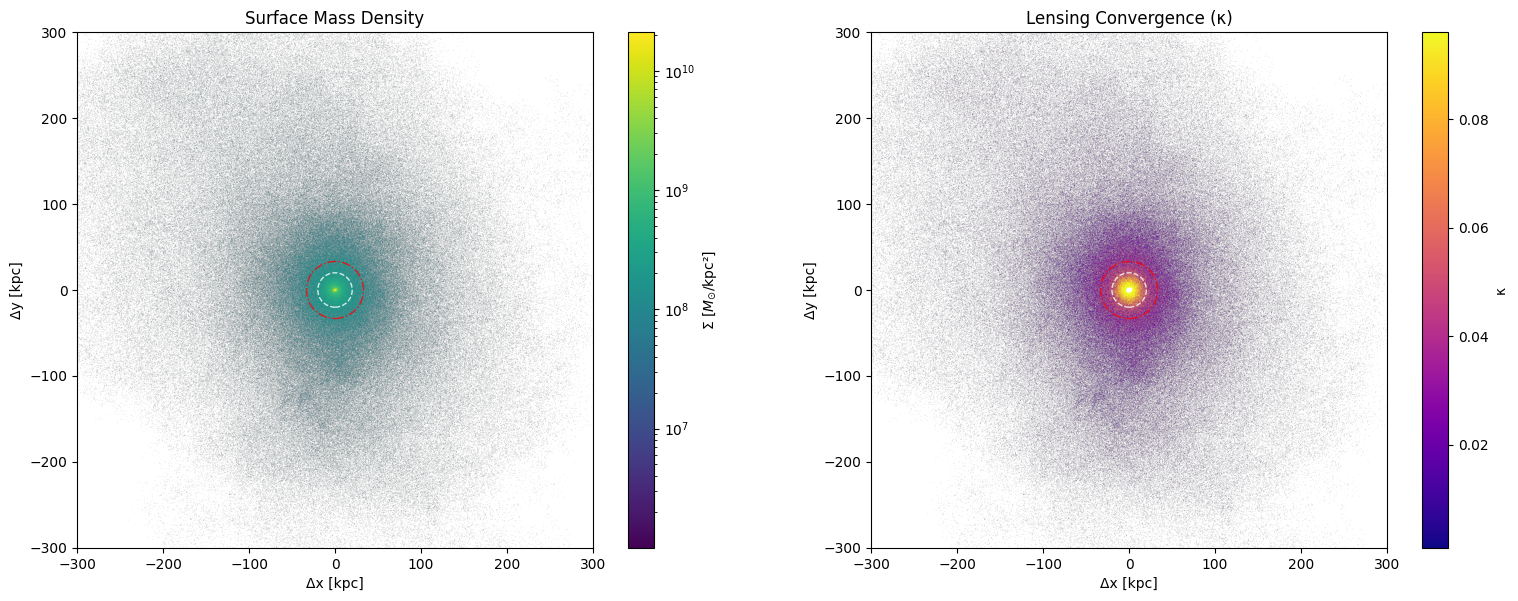


Convergence data stored in 'convergence_data' dictionary
Ready for lenstronomy INTERPOL class.


In [120]:
# Compute lensing convergence (κ) from 2D surface mass density
from matplotlib.colors import LogNorm
print("Computing lensing convergence (κ) from IllustrisTNG galaxy...")
print("=" * 60)

# Cosmological and lensing parameters
z_lens = 0.7   # Lens (galaxy) redshift
z_source = 1.0  # Source redshift (background galaxy/quasar)

# Angular diameter distances using TNG cosmology
D_l = cosmo.angular_diameter_distance(z_lens)     # Distance to lens
D_s = cosmo.angular_diameter_distance(z_source)   # Distance to source  
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)  # Lens-source distance

print(f"Angular diameter distances:")
print(f"D_l (lens at z={z_lens}): {D_l:.1f}")
print(f"D_s (source at z={z_source}): {D_s:.1f}")
print(f"D_ls (lens-source): {D_ls:.1f}")

# Critical surface density for lensing
# Σ_crit = (c²/4πG) × (D_s)/(D_l × D_ls)


c = const.c  # Speed of light
G = const.G  # Gravitational constant

# Calculate critical surface density
Sigma_crit = (c**2 / (4 * np.pi * G)) * (D_s / (D_l * D_ls))
Sigma_crit = Sigma_crit.to(u.Msun / u.kpc**2)  # Convert to solar masses per kpc²

print(f"\nCritical surface density:")
print(f"Σ_crit = {Sigma_crit:.3e}")

# Get the 2D surface mass density from our histogram (NOT the log version!)
surface_mass_density = galaxy_data['histogram_2d']  # M_sun per bin
pixel_area_kpc2 = (pixel_size_kpc)**2  # kpc² per pixel
xedges = galaxy_data['xedges']  # x edges of the histogram
yedges = galaxy_data['yedges']  # y edges of the histogram


# Convert from total mass per bin to surface mass density (M_sun/kpc²)
surface_density_map = surface_mass_density / pixel_area_kpc2  # M_sun/kpc²

print(f"\nSurface mass density statistics:")
print(f"Pixel area: {pixel_area_kpc2:.4f} kpc²")
print(f"Total mass in map: {np.sum(surface_mass_density):.3e} M_sun")
print(f"Max surface density: {np.max(surface_density_map):.3e} M_sun/kpc²")
print(f"Min surface density: {np.min(surface_density_map):.3e} M_sun/kpc²")

# Compute convergence κ = Σ(x,y) / Σ_crit
kappa_map = surface_density_map / Sigma_crit.value

print(f"\nConvergence (κ) statistics:")
print(f"Max κ: {np.max(kappa_map):.4f}")
print(f"Min κ: {np.min(kappa_map):.4f}")
print(f"Mean κ: {np.mean(kappa_map):.4f}")
print(f"κ > 1 (strong lensing): {np.sum(kappa_map > 1)} pixels")
print(f"κ > 0.5: {np.sum(kappa_map > 0.5)} pixels")

# Create visualization of convergence map
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Surface mass density
im1 = axes[0].imshow(surface_density_map.T, origin='lower',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     cmap='viridis', norm=LogNorm())
axes[0].set_title('Surface Mass Density')
axes[0].set_xlabel('Δx [kpc]')
axes[0].set_ylabel('Δy [kpc]')
plt.colorbar(im1, ax=axes[0], label=r'Σ [$M_{\odot}$/kpc²]')

# Add reference circles
for ax in axes:
    circle_1 = plt.Circle((0, 0), radius_cutoff*0.5, fill=False, color='white',
                          linestyle='--', linewidth=1, alpha=0.8)
    circle_2 = plt.Circle((0, 0), radius_cutoff*0.83, fill=False, color='red',
                          linestyle='-.', linewidth=1, alpha=0.8)
    ax.add_patch(circle_1)
    ax.add_patch(circle_2)

# Plot 2: Convergence map
# Mask zero values for better visualization
kappa_masked = np.copy(kappa_map)
kappa_masked[kappa_masked <= 0] = np.nan

im2 = axes[1].imshow(kappa_masked.T, origin='lower',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     cmap='plasma', vmin=0.001, vmax=np.percentile(kappa_map[kappa_map > 0], 99))
axes[1].set_title('Lensing Convergence (κ)')
axes[1].set_xlabel('Δx [kpc]')
axes[1].set_ylabel('Δy [kpc]')
plt.colorbar(im2, ax=axes[1], label='κ')

# Add critical curves (κ = 1) as contours
axes[1].contour(kappa_map.T, levels=[1.0], colors='white', linewidths=2,
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.tight_layout()
plt.show()

# Store convergence data for lenstronomy
convergence_data = {
    'kappa_map': kappa_map,
    'surface_density_map': surface_density_map,
    'Sigma_crit': Sigma_crit.value,
    'z_lens': z_lens,
    'z_source': z_source,
    'D_l': D_l.value,
    'D_s': D_s.value,
    'D_ls': D_ls.value,
    'pixel_size_kpc': pixel_size_kpc,
    'xedges': xedges,
    'yedges': yedges
}

print(f"\nConvergence data stored in 'convergence_data' dictionary")
print(f"Ready for lenstronomy INTERPOL class.")

## Lensing convergence in arsconds grid

Plotting convergence map with angular coordinates (arcseconds)...


/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_11665/2568421811.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


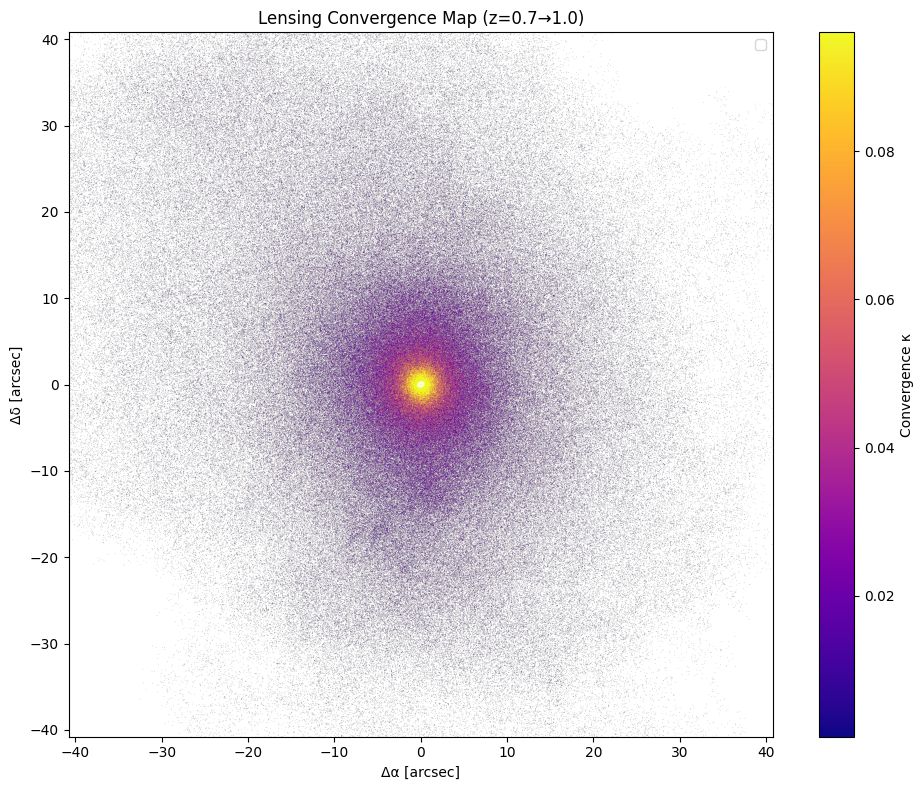

Angular pixel size: 0.0697 arcsec /pixel
Map extent: ±40.8 arcsec


In [121]:
# Plot convergence map in arcseconds
print("Plotting convergence map with angular coordinates (arcseconds)...")

# Convert physical coordinates to angular coordinates
x_arcsec_edges = (xedges * u.kpc / D_l * u.radian).to(u.arcsec).value
y_arcsec_edges = (yedges * u.kpc / D_l * u.radian).to(u.arcsec).value

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Mask zero values for better visualization
kappa_masked = np.copy(kappa_map)
kappa_masked[kappa_masked <= 0] = np.nan

# Plot convergence in arcsec coordinates
im = ax.imshow(kappa_masked.T, origin='lower',
               extent=[x_arcsec_edges[0], x_arcsec_edges[-1], 
                      y_arcsec_edges[0], y_arcsec_edges[-1]],
               cmap='plasma', vmin=0.001, vmax=np.percentile(kappa_map[kappa_map > 0], 99))

plt.colorbar(im, ax=ax, label='Convergence κ')
ax.set_xlabel('Δα [arcsec]')
ax.set_ylabel('Δδ [arcsec]')
ax.set_title(f'Lensing Convergence Map (z={z_lens}→{z_source})')

# Add critical curves (κ = 1) as contours
ax.contour(kappa_map.T, levels=[1.0], colors='white', linewidths=2, alpha=0.8,
           extent=[x_arcsec_edges[0], x_arcsec_edges[-1], 
                  y_arcsec_edges[0], y_arcsec_edges[-1]])

# Add reference circles in arcsec
for r_kpc in [radius_cutoff*0.33, radius_cutoff*0.5, radius_cutoff*0.67]:
    r_arcsec = (r_kpc * u.kpc / D_l * u.radian).to(u.arcsec).value
    circle = plt.Circle((0, 0), r_arcsec, fill=False, color='cyan',
                       linestyle='--', linewidth=1, alpha=0.6, 
                       label=f'{r_kpc:.0f} kpc' if r_kpc == radius_cutoff*0.33 else '')

ax.legend()
plt.tight_layout()
plt.show()

print(f"Angular pixel size: {angular_size_arcsec:.4f} /pixel")
print(f"Map extent: ±{x_arcsec_edges[-1]:.1f} arcsec")

In [122]:

# Use the previously calculated parameters from IllustrisTNG data
Delta_pix = round(angular_size_arcsec.to(u.arcsec).value, 5)  # pixel size in arcseconds
numPix = kappa_map.shape[0]  # Use the TNG convergence map dimensions

print(f"Delta_pix = {Delta_pix:.5f} arcsec/pixel")
print(f"numPix = {numPix} pixels")
print(f"Map size = {numPix * Delta_pix:.3f} arcsec")

# Create angular coordinate grids for lenstronomy
x_angular = np.linspace(-numPix/2 * Delta_pix, numPix/2 * Delta_pix, numPix)
y_angular = np.linspace(-numPix/2 * Delta_pix, numPix/2 * Delta_pix, numPix)

print(f"Angular coordinate range: ±{x_angular[-1]:.3f} arcsec")
print("Lensing potential computed successfully!")

Delta_pix = 0.06966 arcsec/pixel
numPix = 2000 pixels
Map size = 139.320 arcsec
Angular coordinate range: ±69.660 arcsec
Lensing potential computed successfully!


## Lenstronomy's built-in lensing potential function $\Psi$

we use Lenstronomy's "convergence_integrals" module

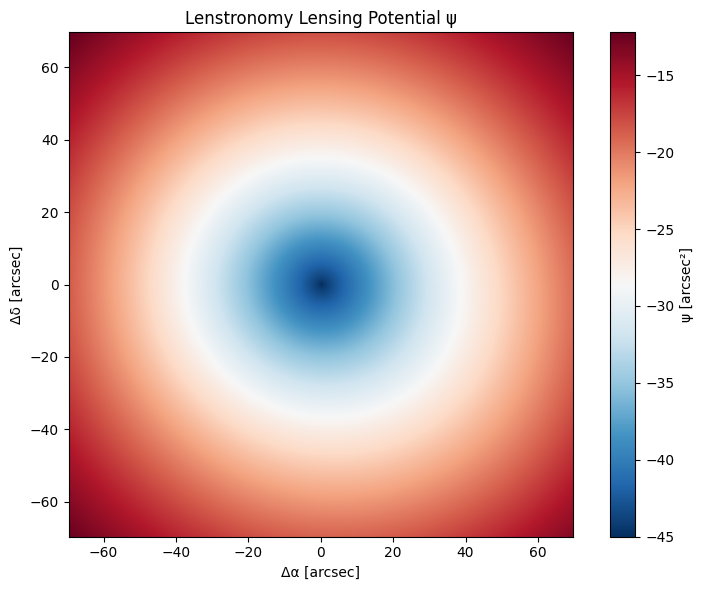

Lenstronomy potential range: [-45.0074, -12.2023] arcsec²


In [123]:
from lenstronomy.LensModel import convergence_integrals

lenstronomy_lensing_potential = convergence_integrals.potential_from_kappa_grid(kappa_map, Delta_pix)

# Plot lenstronomy lensing potential
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(lenstronomy_lensing_potential, origin='lower', cmap='RdBu_r',
               extent=[x_angular[0], x_angular[-1], y_angular[0], y_angular[-1]])
ax.set_xlabel('Δα [arcsec]')
ax.set_ylabel('Δδ [arcsec]')
ax.set_title('Lenstronomy Lensing Potential ψ')
plt.colorbar(im, ax=ax, label='ψ [arcsec²]')
plt.tight_layout()
plt.show()

print(f"Lenstronomy potential range: [{np.min(lenstronomy_lensing_potential):.4f}, {np.max(lenstronomy_lensing_potential):.4f}] arcsec²")

### Compute Deflection angles using built-in function

Deflection angles are first derivatives of the lensing potential

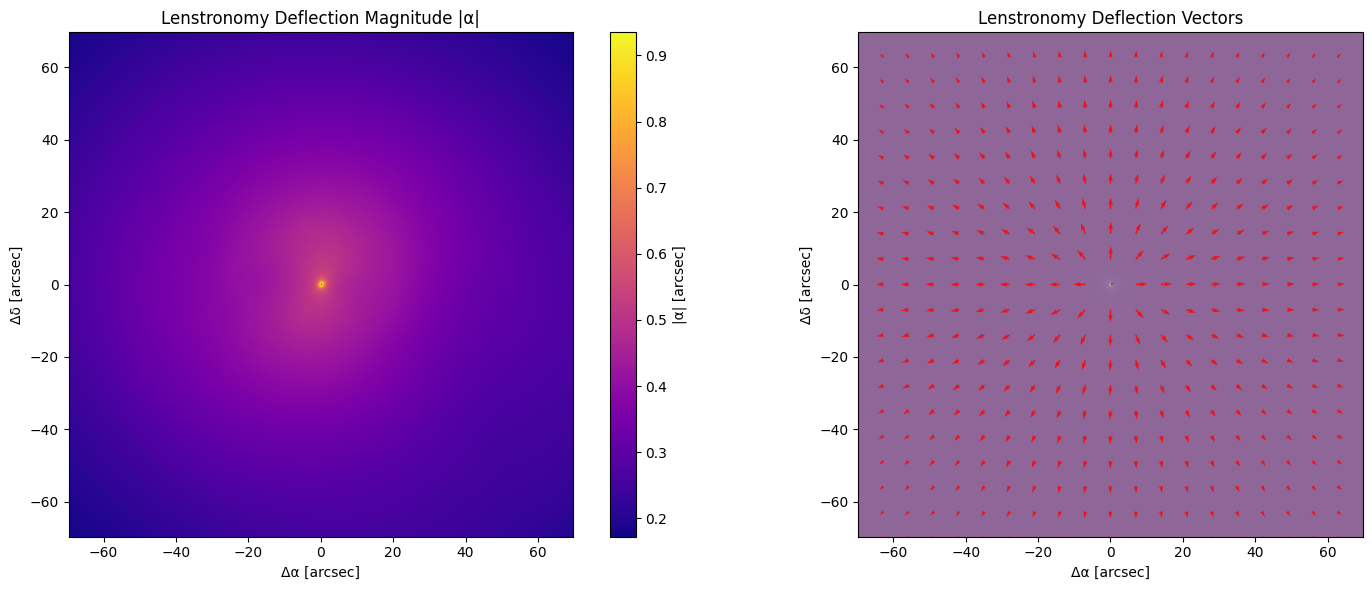

Lenstronomy deflection range: [0.1721, 0.9349] arcsec


In [124]:
alpha_x_lenstronomy, alpha_y_lenstronomy = convergence_integrals.deflection_from_kappa_grid(kappa_map, Delta_pix)

# Plot lenstronomy deflection angles
deflection_mag_ls = np.sqrt(alpha_x_lenstronomy**2 + alpha_y_lenstronomy**2)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Deflection magnitude
im1 = axes[0].imshow(deflection_mag_ls, origin='lower', cmap='plasma',
                     extent=[x_angular[0], x_angular[-1], y_angular[0], y_angular[-1]])
axes[0].set_xlabel('Δα [arcsec]')
axes[0].set_ylabel('Δδ [arcsec]')
axes[0].set_title('Lenstronomy Deflection Magnitude |α|')
plt.colorbar(im1, ax=axes[0], label='|α| [arcsec]')

# Plot 2: Vector field
step = max(1, numPix // 20)
X_sub, Y_sub = np.meshgrid(x_angular[::step], y_angular[::step])
axes[1].imshow(kappa_map, origin='lower', alpha=0.6, cmap='viridis',
               extent=[x_angular[0], x_angular[-1], y_angular[0], y_angular[-1]])
axes[1].quiver(X_sub, Y_sub, alpha_x_lenstronomy[::step, ::step], alpha_y_lenstronomy[::step, ::step],
               scale=20, color='red', alpha=0.8, width=0.003)
axes[1].set_xlabel('Δα [arcsec]')
axes[1].set_ylabel('Δδ [arcsec]')
axes[1].set_title('Lenstronomy Deflection Vectors')

plt.tight_layout()
plt.show()

print(f"Lenstronomy deflection range: [{np.min(deflection_mag_ls):.4f}, {np.max(deflection_mag_ls):.4f}] arcsec")

## Set-up TNG data for Lenstronomy Simulation

In [125]:
# Setup TNG data for lenstronomy INTERPOL model
print("Setting up TNG data for lenstronomy INTERPOL model...")

# We now have all the required components from TNG:
# - x_angular, y_angular: coordinate grids
# - lenstronomy_lensing_potential: lensing potential ψ
# - alpha_x_lenstronomy, alpha_y_lenstronomy: deflection angles

print("TNG lensing data ready for lenstronomy simulation:")
print(f"- Grid size: {numPix}x{numPix} pixels")
print(f"- Pixel scale: {Delta_pix:.5f} arcsec/pixel")
print(f"- Angular extent: ±{x_angular[-1]:.3f} arcsec")
print(f"- Potential range: [{np.min(lenstronomy_lensing_potential):.4f}, {np.max(lenstronomy_lensing_potential):.4f}] arcsec²")
print(f"- Max deflection: {np.sqrt(np.max(alpha_x_lenstronomy**2 + alpha_y_lenstronomy**2)):.4f} arcsec")

Setting up TNG data for lenstronomy INTERPOL model...
TNG lensing data ready for lenstronomy simulation:
- Grid size: 2000x2000 pixels
- Pixel scale: 0.06966 arcsec/pixel
- Angular extent: ±69.660 arcsec
- Potential range: [-45.0074, -12.2023] arcsec²
- Max deflection: 0.9349 arcsec


### Select a small region around the galactic subhalo centre for simulation

this is the region where the gravitational potential from baryonic+DM is strongest for significant lensing to occur and for lensed images of a background source to form

In [127]:
# Mask to 8x8 arcsecond region for simulation
region_size_arcsec = 8.0  # Size of the region in arcseconds

# Create mask for the central region
center_idx = numPix // 2
half_region_pixels = int(region_size_arcsec / (2 * Delta_pix))
start_idx = center_idx - half_region_pixels
end_idx = center_idx + half_region_pixels

# Ensure indices are within bounds
start_idx = max(0, start_idx)
end_idx = min(numPix, end_idx)

# Extract masked coordinate arrays (1D)
x_angular_masked = x_angular[start_idx:end_idx]
y_angular_masked = y_angular[start_idx:end_idx]

# Extract masked 2D arrays
lensing_potential_masked = lenstronomy_lensing_potential[start_idx:end_idx, start_idx:end_idx]
alpha_x_masked = alpha_x_lenstronomy[start_idx:end_idx, start_idx:end_idx]
alpha_y_masked = alpha_y_lenstronomy[start_idx:end_idx, start_idx:end_idx]
kappa_masked = kappa_map[start_idx:end_idx, start_idx:end_idx]

print(f"Masked region: {region_size_arcsec}x{region_size_arcsec} arcsec")
print(f"Masked grid: {len(x_angular_masked)}x{len(y_angular_masked)} pixels")
print(f"Masked extent: [{x_angular_masked[0]:.2f}, {x_angular_masked[-1]:.2f}] arcsec")
print(f"Variables stored: x_angular_masked, y_angular_masked, lensing_potential_masked, alpha_x_masked, alpha_y_masked, kappa_masked")

Masked region: 8.0x8.0 arcsec
Masked grid: 114x114 pixels
Masked extent: [-3.94, 3.94] arcsec
Variables stored: x_angular_masked, y_angular_masked, lensing_potential_masked, alpha_x_masked, alpha_y_masked, kappa_masked


In [128]:
#data specifics for TNG simulation
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 5000.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix_sim = int(x_angular_masked.shape[0])  #  cutout pixel size for simulation (smaller than full TNG map)
deltaPix = Delta_pix  #  pixel size in arcsec from TNG data
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kernel_size = 91

print(f"Simulation parameters:")
print(f"- Simulation grid: {numPix_sim}x{numPix_sim} pixels")
print(f"- Pixel scale: {deltaPix:.5f} arcsec/pixel")
print(f"- Field of view: {numPix_sim * deltaPix:.3f} arcsec")

# initial input simulation
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix_sim, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)

# generate the psf variables
kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
psf_class = PSF(**kwargs_psf)

Simulation parameters:
- Simulation grid: 114x114 pixels
- Pixel scale: 0.06966 arcsec/pixel
- Field of view: 7.941 arcsec


### Setup the simulation input model using the INTERPOL class

Point source position at :  (0.05, 0.06) arcsec
Finding lensed image positions...
Found 3 lensed images at positions:
  Image 1: (0.744, 0.312) arcsec, magnification = 11.63
  Image 2: (-0.350, -0.624) arcsec, magnification = -2.61
  Image 3: (-0.017, -0.017) arcsec, magnification = 0.10
Displaying TNG-based strong lensing simulation...


/var/folders/yb/5h1_fmpd1g3_5sy82wzy3q140000gn/T/ipykernel_11665/3142475796.py:107: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap,


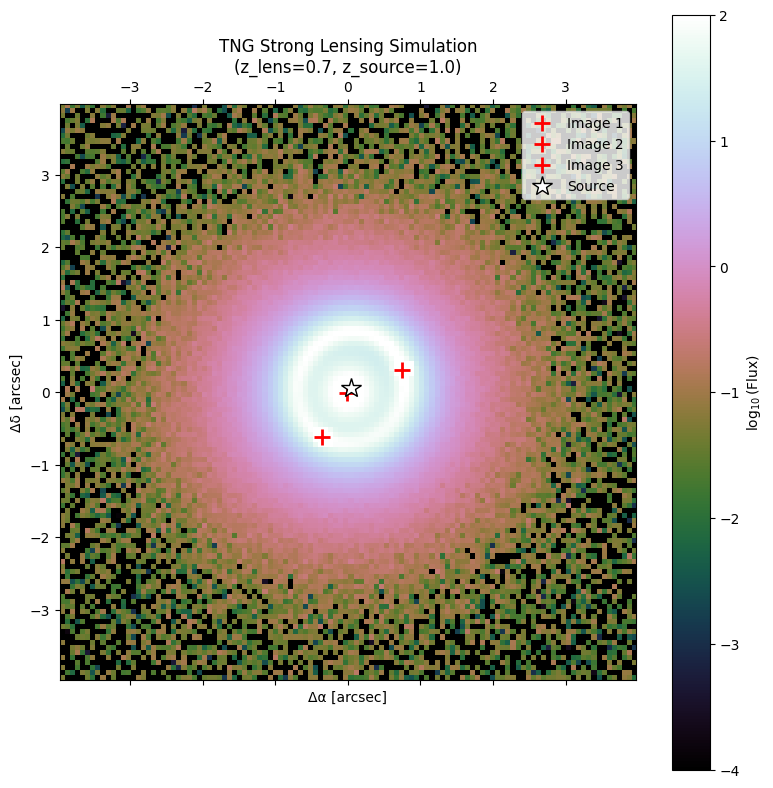

TNG lensing simulation completed!
Simulation shows lensing by IllustrisTNG galaxy with 40.0 kpc cutoff
Pixel scale: 0.06966 arcsec, Field of view: 7.94 arcsec


In [ ]:
# %% Set up the TNG Input Model

z_lens = 0.7  # lens redshift (from TNG data)
z_source = 1.0  # source redshift (from TNG data)
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)  # TNG cosmology parameters


# lensing quantities - use TNG data with INTERPOL model
lens_model_list = ['INTERPOL']

# For INTERPOL model, we need:
# - grid_interp_x, grid_interp_y: 1D arrays defining the coordinate grid
# - f_, f_x, f_y: 2D arrays of potential and deflection angles
kwargs_lens = [{ 
    'grid_interp_x': x_angular_masked,  # Original 1D coordinate arrays
    'grid_interp_y': y_angular_masked,
    'f_': lensing_potential_masked,  # 2D masked potential array
    'f_x': alpha_x_masked,             # 2D deflection angle arrays
    'f_y': alpha_y_masked
}]

lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)




# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

#point source position
source_x = 0.05
source_y = 0.06

print("Point source position at : ", (source_x, source_y), "arcsec")


# list of light profiles (for lens and source)
# 'SERSIC': Sersic profile of source

phi_G, q = 0.5, 0.8
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 6000, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
#phi_G, q = 0.9, 0.9
#e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.4, 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# Lensed Image positions
print("Finding lensed image positions...")

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=Delta_pix, search_window=numPix_sim * Delta_pix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

print(f"Found {len(x_image)} lensed images at positions:")
for i, (x, y, m) in enumerate(zip(x_image, y_image, mag)):
    print(f"  Image {i+1}: ({x:.3f}, {y:.3f}) arcsec, magnification = {m:.2f}")

kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the TNG-based lensing simulation
print("Displaying TNG-based strong lensing simulation...")

cmap_string = 'cubehelix'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, 
                extent=[-numPix_sim*deltaPix/2, numPix_sim*deltaPix/2, 
                       -numPix_sim*deltaPix/2, numPix_sim*deltaPix/2])
ax.set_xlabel('Δα [arcsec]')
ax.set_ylabel('Δδ [arcsec]')
ax.set_title(f'TNG Strong Lensing Simulation\n(z_lens={z_lens}, z_source={z_source})')

# Mark the lensed image positions
for i, (x, y) in enumerate(zip(x_image, y_image)):
    ax.plot(x, y, 'r+', markersize=12, markeredgewidth=2, label=f'Image {i+1}')  #if i == 0 else '')

# Mark the source position
ax.plot(source_x, source_y, 'w*', markersize=15, markeredgewidth=1, markeredgecolor='black', label='Source')

ax.legend()
plt.colorbar(im, ax=ax, label=r'$\log_{10}$(Flux)')
plt.tight_layout()
plt.show()

print(f"TNG lensing simulation completed!")
print(f"Pixel scale: {deltaPix:.5f} arcsec, Field of view: {numPix_sim*deltaPix:.2f} arcsec")

### Compute Time delays between the lensed point sources

In [ ]:
# %% Compute Time Delays for INTERPOL model

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays
dt_sigma = [1, 1, 1]  # Gaussian errors

# and here a realisation of the measurement with the quoted errors
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the true relative delays are: ", dt_days)
print("the simulated measured relative delays are: ", dt_measured)

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
print(lensCosmo.ddt)

fermat_pot = td_cosmo.fermat_potential(kwargs_lens, kwargs_ps)
delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
print(delta_fermat_12)

the time delays for the images at position  [ 0.3077635   0.47275187  0.71974345 -0.52590027] [ 0.67527111 -0.54600575 -0.13795747 -0.04682121] are:  [11348.62109209 11351.63407035 11352.14594592 11367.69391882]
the true relative delays are:  [ 3.01297827  3.52485384 19.07282674]
the simulated measured relative delays are:  [ 1.5872641   4.94960299 18.75901712]
4555.37593033449
-0.027634464766521205


## Setup Likelihood, constraints and Inference for a given Lens Model

In [ ]:

kwargs_model_fit = {'lens_model_list': ['EPL_BOXYDISKY', 'SHEAR'],
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }


num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

# additional likelihood added for computing time delays

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     
                     #'source_position_likelihood': True,  # Enable this to use tolerance
                     'source_position_tolerance': 0.001,
                     'time_delay_likelihood': True,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}


# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0.05, 'e2': 0.05, 'a4_a':0.001})
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.05, 'e2': 0.05, 'gamma': 0.1, 'center_x': 0.01, 'center_y': 0.01, 'a4_a':0.015})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10, 'a4_a':-0.2})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10, 'a4_a':0.2})


fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.5, 'gamma2': -0.5})
kwargs_upper_lens.append({'gamma1': 0.5, 'gamma2': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

# Source light model choices
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'R_sersic': 0.05, 'n_sersic': 0.5,'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

# Cosmological parameters for time delay fitting
fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 5000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

# Complete parameter setup
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}






### Perform PSO+MCMC fitting to infer lensing and cosmographic parameters

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model_fit, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 200, 'n_iterations': 1000}],
        ['MCMC', {'n_burn': 500, 'n_run': 1000, 'walkerRatio': 15, 'sigma_scale': .05}]]


start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print((end_time - start_time)/3600, 'total time needed for computation')


## Plot results of inference

In [ ]:
# %% Plot Results
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model_fit, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])



plot1 = corner.corner(samples_mcmc[:,:12], labels=param_mcmc[:12], show_titles=True)
plot2 = corner.corner(samples_mcmc[:,12:], labels=param_mcmc[12:], show_titles=True)

In [ ]:

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = w_r * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()